In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from IPython.display import Image
import cv2 as cv
import os
import pydot
from tensorflow.keras.layers import Dropout
from skimage.metrics import peak_signal_noise_ratio ,structural_similarity,mean_squared_error
import pickle
import sys
sys.path.append('/kaggle/input/imd_precip_library/other/default/5')
from Data_processing_zero import Data_Processing as dp
from Data_processing_zero import Training as tn
from keras.models import load_model

# Data Processing and Visualisation

In [2]:
SR_file_path = '/kaggle/input/imd-lr-sr/data/data.pkl'
with open(SR_file_path, 'rb') as file:
    SR_data = pickle.load(file)

In [3]:
SR_data_base,Metadata = dp.process_base_data(SR_data)

In [4]:
SR_data_processed,LR_data_processed,Metadata,daily_max = dp.generate_dataset(SR_data_base,Metadata)

Step 1 completed
Step 2 completed
Step 3 completed
Step 4 completed
Step 5 completed


In [5]:
SR_mask,LR_mask = dp.create_mask([SR_data_base[0]])

32 32
(32, 32)


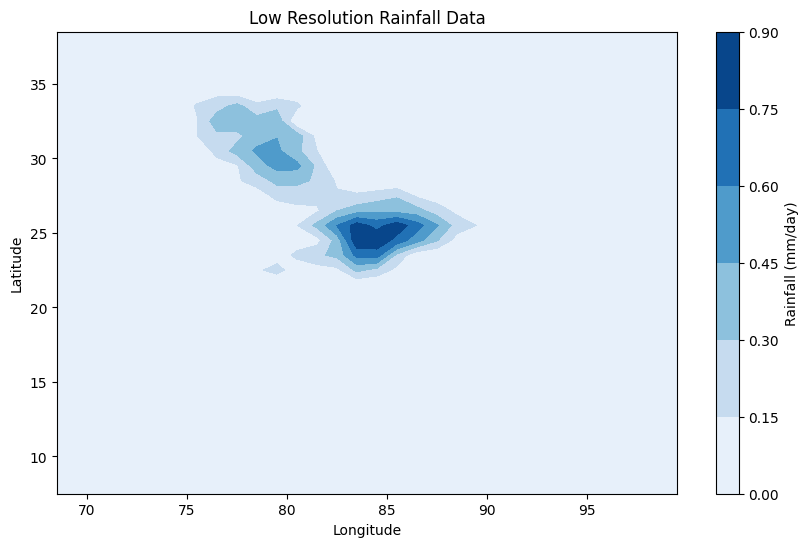

128 128


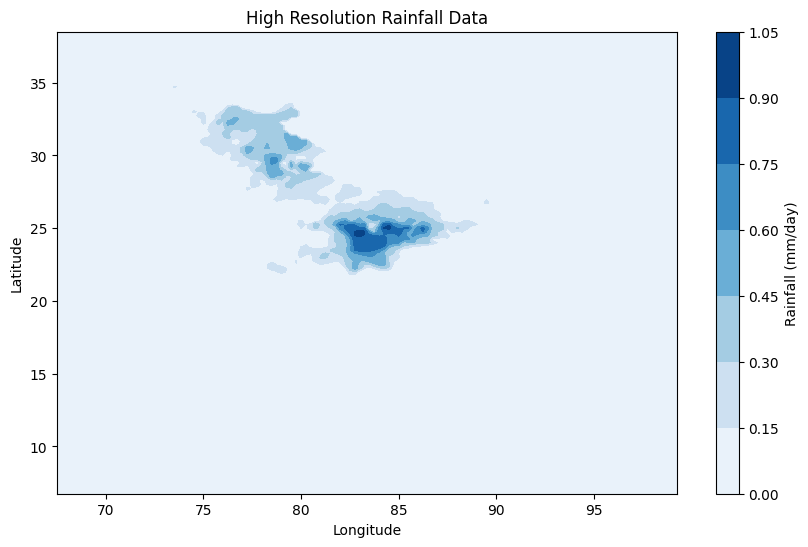

In [6]:
dp.visualize_LR_data(LR_data_processed[0])
dp.visualize_SR_data(SR_data_processed[0])

# Generator

In [7]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope


class DepthToSpaceLayer(tf.keras.layers.Layer):
    def __init__(self, block_size, **kwargs):
        super(DepthToSpaceLayer, self).__init__(**kwargs)
        self.block_size = block_size

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.block_size)

    def get_config(self):
        config = super(DepthToSpaceLayer, self).get_config()
        config.update({"block_size": self.block_size})
        return config

with custom_object_scope({'DepthToSpaceLayer': DepthToSpaceLayer}):
    Generator = load_model('/kaggle/input/epoch_5/tensorflow2/total_8_epochs/3/generator_epoch_24.h5')
Generator.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 1)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │        640 │ input_layer[0][0] │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, None,      │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None,      │     74,368 │ leaky_re_lu[0][0] │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None,      │          0 │ leaky_re_lu[0][0… │
│                     │ None, 64)         │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, None,      │     74,368 │ add[0][0]         │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None,      │          0 │ add[0][0],        │
│                     │ None, 64)         │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, None,      │     74,368 │ add_1[0][0]       │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None,      │          0 │ add_1[0][0],      │
│                     │ None, 64)         │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, None,      │     74,368 │ add_2[0][0]       │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, None,      │          0 │ add_2[0][0],      │
│                     │ None, 64)         │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, None,      │     74,368 │ add_3[0][0]       │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, None,      │          0 │ add_3[0][0],      │
│                     │ None, 64)         │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, None,      │     74,368 │ add_4[0][0]       │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, None,      │          0 │ add_4[0][0],      │
│                     │ None, 64)         │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, None,      │     74,368 │ add_5[0][0]       │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, None,      │          0 │ add_5[0][0],    

 Total params: 928,769 (3.54 MB)

 Trainable params: 926,593 (3.53 MB)

 Non-trainable params: 2,176 (8.50 KB)

# Discriminator

In [8]:
discriminator = load_model('/kaggle/input/epoch_5/tensorflow2/total_8_epochs/3/discriminator_epoch_24.h5')
discriminator.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_11 (Sequential)      │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_12 (Sequential)      │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_13 (Sequential)      │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_14 (Sequential)      │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    33,555,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_27 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,240,705 (145.88 MB)

 Trainable params: 38,240,705 (145.88 MB)

 Non-trainable params: 0 (0.00 B)

# Feature Extractor

In [9]:
from keras.models import load_model
def my_custom_loss(y_true, y_pred):
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return 0.9 * ssim_loss + 0.1* mse_loss
model = load_model('/kaggle/input/autoencoder_zero/tensorflow2/default/1/autoencoder_fe (1).keras',custom_objects={'combined_loss': my_custom_loss})
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('latent_space').output)

# Training

In [10]:
PSNR = []
SSIM = []
MSE = []

generator_optimizer = tf.keras.optimizers.Adam(5e-4, beta_1=0.0, beta_2=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-4, beta_1=0.0, beta_2=0.5)

def train_step(SR_images, LR_images, batch_size):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = Generator(LR_images, training=True)
        real_output = discriminator(SR_images, training=True)
        fake_output = discriminator(fake_images, training=True)
        gp = tn.gradient_penalty(discriminator, SR_images, fake_images)
        gen_loss = tn.generator_loss(fake_output, SR_images, fake_images, feature_extractor,1,1,1)
        disc_loss = tn.discriminator_loss(real_output, fake_output, gp)
    
    # Compute gradients for the generator, discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, Generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Apply gradients to update the weights
    generator_optimizer.apply_gradients(zip(gradients_of_generator, Generator.trainable_variables ))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

# Training loop
def train(SR_data, LR_data,PSNR,SSIM, epochs, batch_size):
    for epoch in range(epochs):
        indices = np.arange(len(SR_data))
        np.random.shuffle(indices)
        for i in range(len(SR_data)//batch_size):
            batch = indices[i:i+batch_size]
            lr = np.array([LR_data[j] for j in batch]).reshape((batch_size, 32, 32, 1))
            sr = np.array([SR_data[j] for j in batch]).reshape((batch_size, 128, 128, 1))
            gen_loss, disc_loss = train_step(sr, lr, batch_size)
            if i%100==0 and i!=0:
                print(f'{i} batches completed in epoch:{epoch+1}')
        sr_pic = np.array(SR_data[0])
        lr_pic = np.array(LR_data[:32]).reshape((32, 32, 32, 1))
        generated = np.array(Generator(lr_pic))[0].reshape((128,128))
        dp.visualize_SR_masked_data(sr_pic,SR_mask[0])
        dp.visualize_SR_masked_data(generated,SR_mask[0])
        print(f'Epoch {epoch+1}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}')
        Generator.save(f'generator_epoch_{epoch+1}.h5')
        discriminator.save(f'discriminator_epoch_{epoch+1}.h5')
        print(f'Models saved after epoch {epoch+1}')
        psnr,ssim , mse = tn.calculate_metrics(Generator,SR_data,LR_data ,SR_mask[0])
        print(f'PSNR:{psnr},SSIM:{ssim} , MSE:{mse}')
        PSNR.append(psnr)
        SSIM.append(ssim)
        MSE.append(mse)

100 batches completed in epoch:1
200 batches completed in epoch:1
300 batches completed in epoch:1
400 batches completed in epoch:1
500 batches completed in epoch:1
600 batches completed in epoch:1
700 batches completed in epoch:1
800 batches completed in epoch:1
900 batches completed in epoch:1
1000 batches completed in epoch:1
1100 batches completed in epoch:1
1200 batches completed in epoch:1
1300 batches completed in epoch:1
128 128


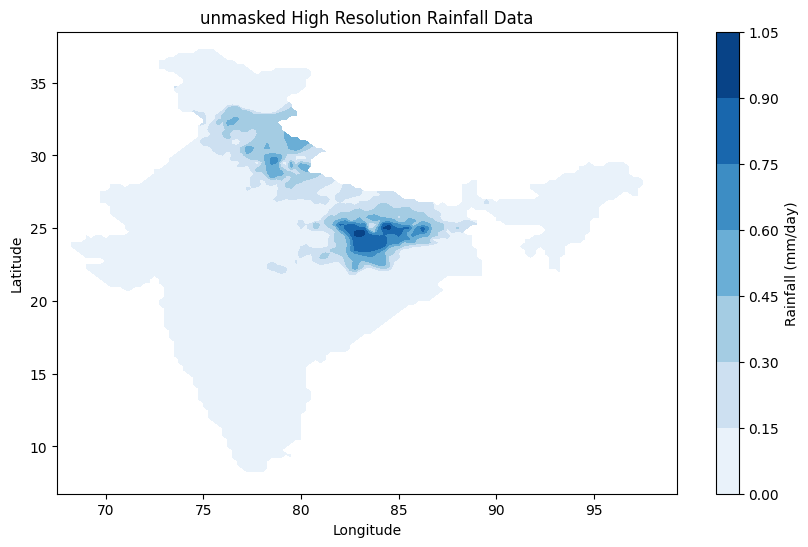

128 128


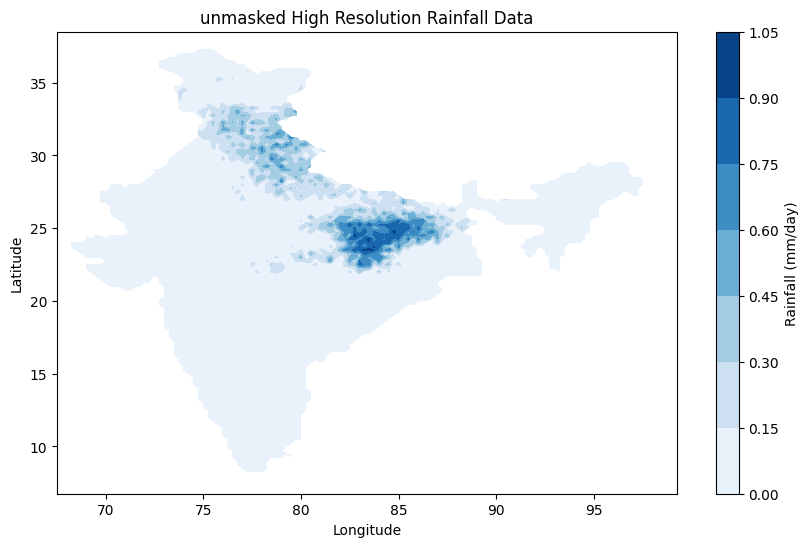

Epoch 1, Generator Loss: 357.5873718261719, Discriminator Loss: -4.592670440673828
Models saved after epoch 1
PSNR:31.691383983940334,SSIM:0.9254473578245918 , MSE:0.0009254839832792555
100 batches completed in epoch:2
200 batches completed in epoch:2
300 batches completed in epoch:2
400 batches completed in epoch:2
500 batches completed in epoch:2
600 batches completed in epoch:2
700 batches completed in epoch:2
800 batches completed in epoch:2
900 batches completed in epoch:2
1000 batches completed in epoch:2
1100 batches completed in epoch:2
1200 batches completed in epoch:2
1300 batches completed in epoch:2
128 128


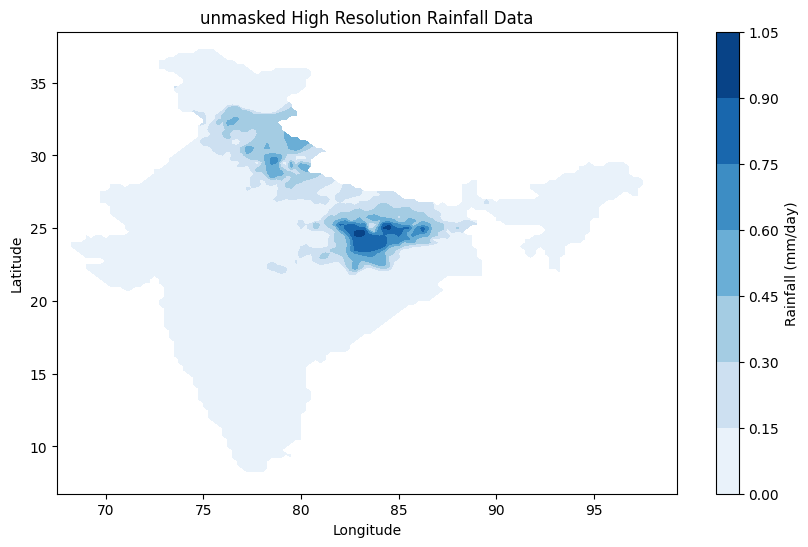

128 128


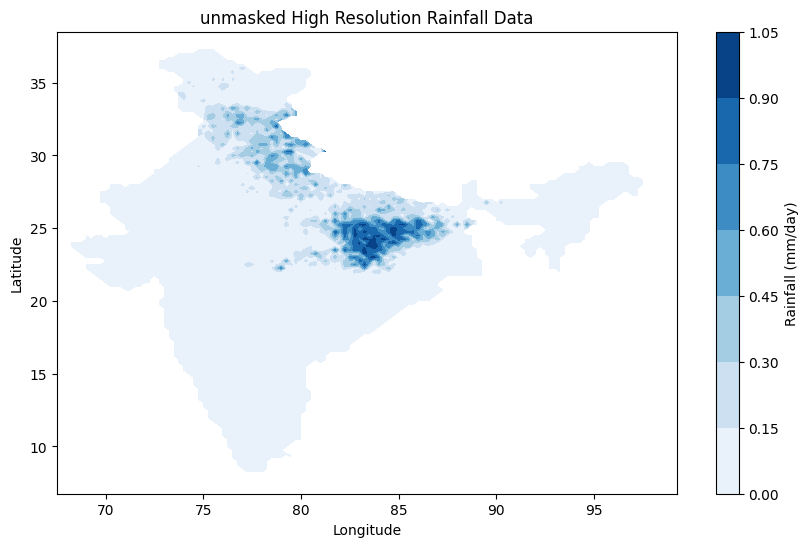

Epoch 2, Generator Loss: 324.20611572265625, Discriminator Loss: -4.205057621002197
Models saved after epoch 2
PSNR:31.677911486162966,SSIM:0.9318626588884926 , MSE:0.0009386181808492424
100 batches completed in epoch:3
200 batches completed in epoch:3
300 batches completed in epoch:3
400 batches completed in epoch:3
500 batches completed in epoch:3
600 batches completed in epoch:3
700 batches completed in epoch:3
800 batches completed in epoch:3
900 batches completed in epoch:3
1000 batches completed in epoch:3
1100 batches completed in epoch:3
1200 batches completed in epoch:3
1300 batches completed in epoch:3
128 128


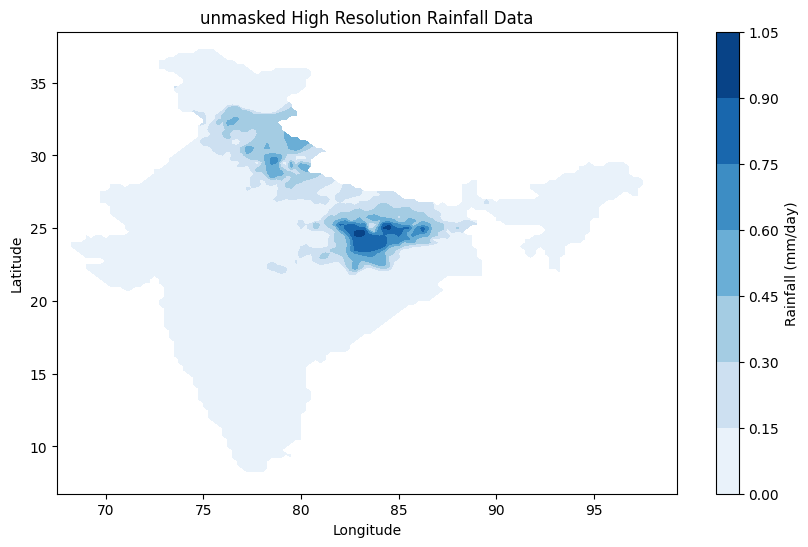

128 128


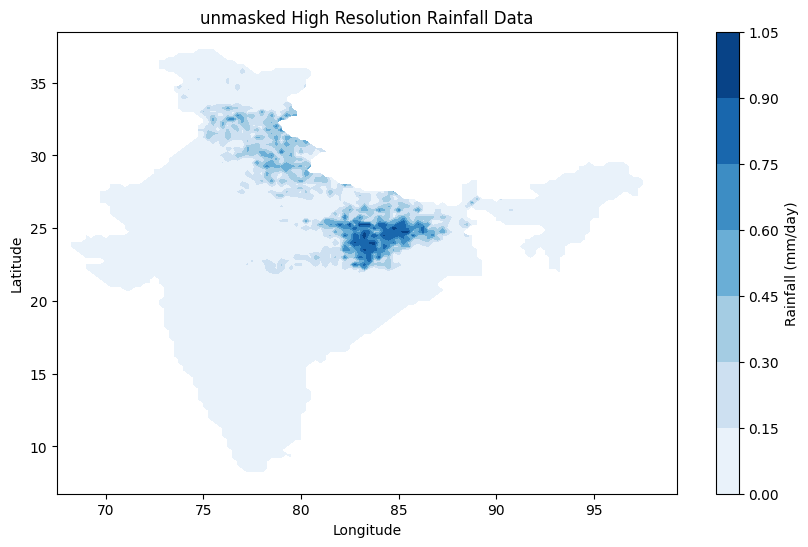

Epoch 3, Generator Loss: 332.42840576171875, Discriminator Loss: -4.265974998474121
Models saved after epoch 3
PSNR:31.679948877405224,SSIM:0.9303636865609246 , MSE:0.0009264365945950373
100 batches completed in epoch:4
200 batches completed in epoch:4
300 batches completed in epoch:4
400 batches completed in epoch:4
500 batches completed in epoch:4
600 batches completed in epoch:4
700 batches completed in epoch:4
800 batches completed in epoch:4
900 batches completed in epoch:4
1000 batches completed in epoch:4
1100 batches completed in epoch:4
1200 batches completed in epoch:4
1300 batches completed in epoch:4
128 128


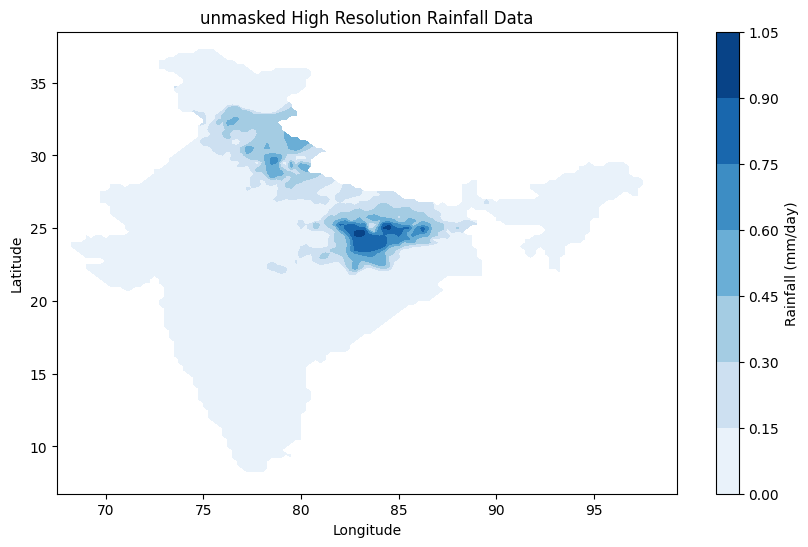

128 128


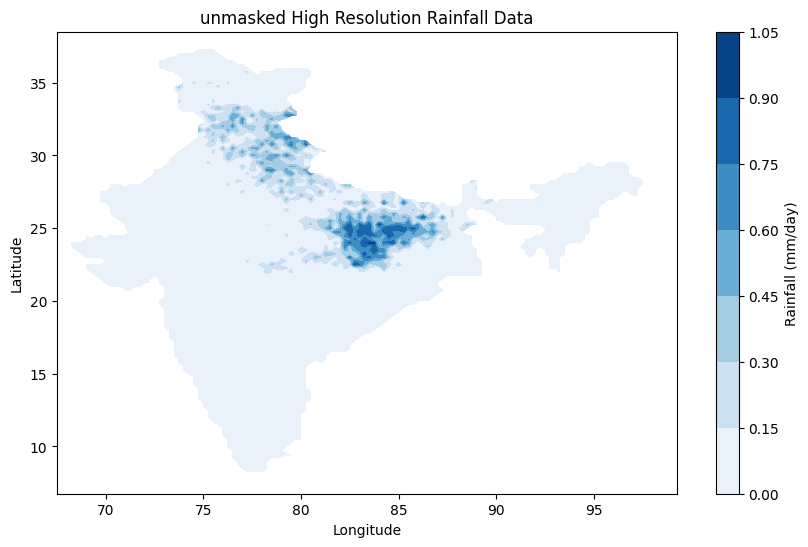

Epoch 4, Generator Loss: 309.1291198730469, Discriminator Loss: -3.922175884246826
Models saved after epoch 4
PSNR:31.60618807591421,SSIM:0.9301461969412449 , MSE:0.0009478283923372978
100 batches completed in epoch:5
200 batches completed in epoch:5
300 batches completed in epoch:5
400 batches completed in epoch:5
500 batches completed in epoch:5
600 batches completed in epoch:5
700 batches completed in epoch:5
800 batches completed in epoch:5
900 batches completed in epoch:5
1000 batches completed in epoch:5
1100 batches completed in epoch:5
1200 batches completed in epoch:5
1300 batches completed in epoch:5
128 128


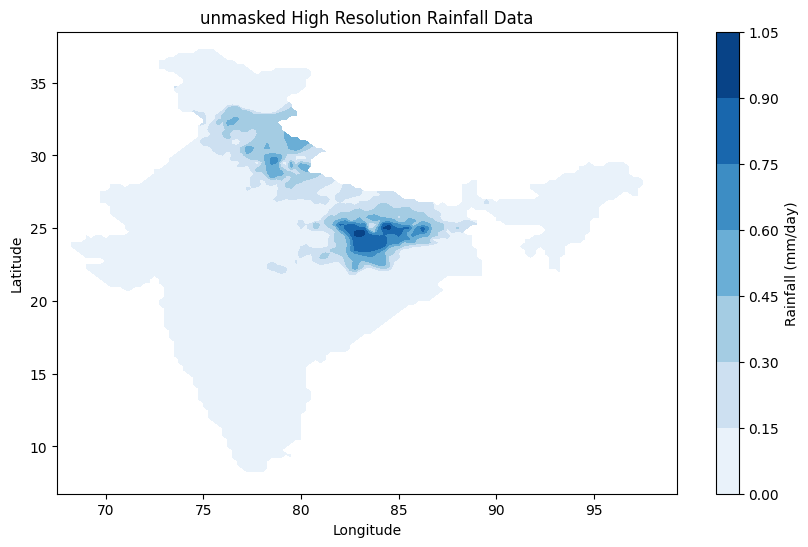

128 128


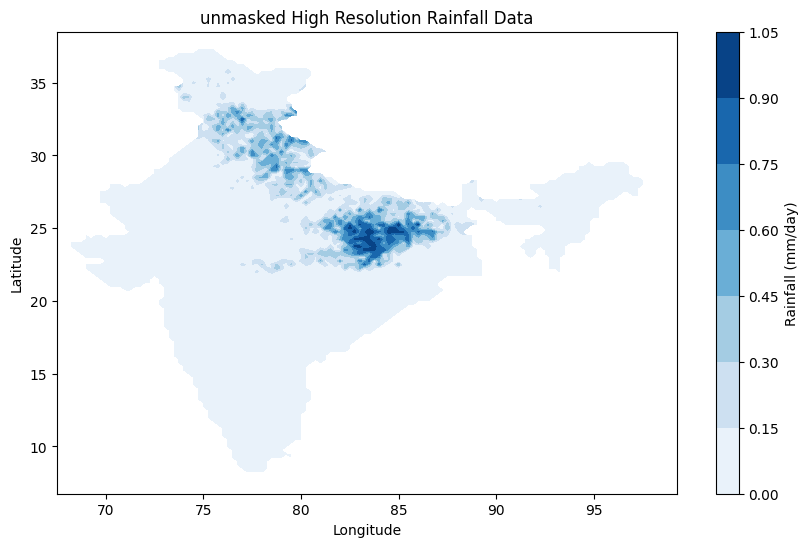

Epoch 5, Generator Loss: 395.0810241699219, Discriminator Loss: -5.135189056396484
Models saved after epoch 5
PSNR:31.32681521655674,SSIM:0.9282826203905886 , MSE:0.0010196604827241045
100 batches completed in epoch:6
200 batches completed in epoch:6
300 batches completed in epoch:6
400 batches completed in epoch:6
500 batches completed in epoch:6
600 batches completed in epoch:6
700 batches completed in epoch:6
800 batches completed in epoch:6
900 batches completed in epoch:6
1000 batches completed in epoch:6
1100 batches completed in epoch:6
1200 batches completed in epoch:6
1300 batches completed in epoch:6
128 128


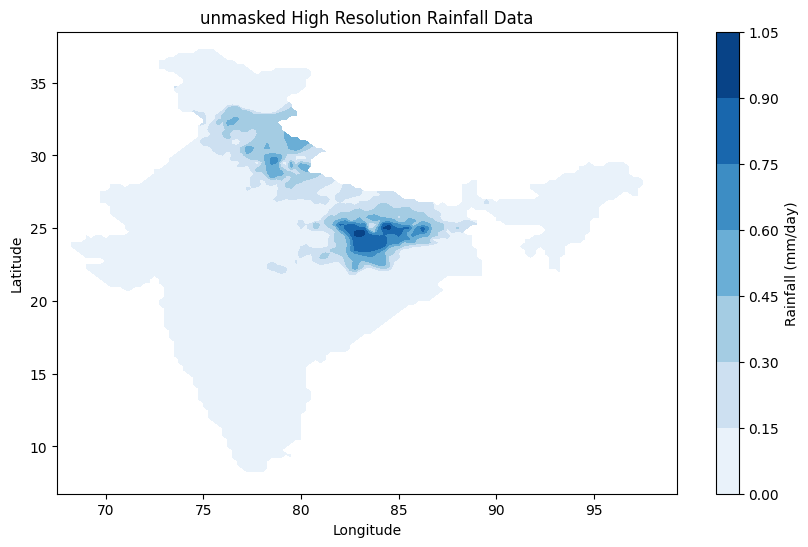

128 128


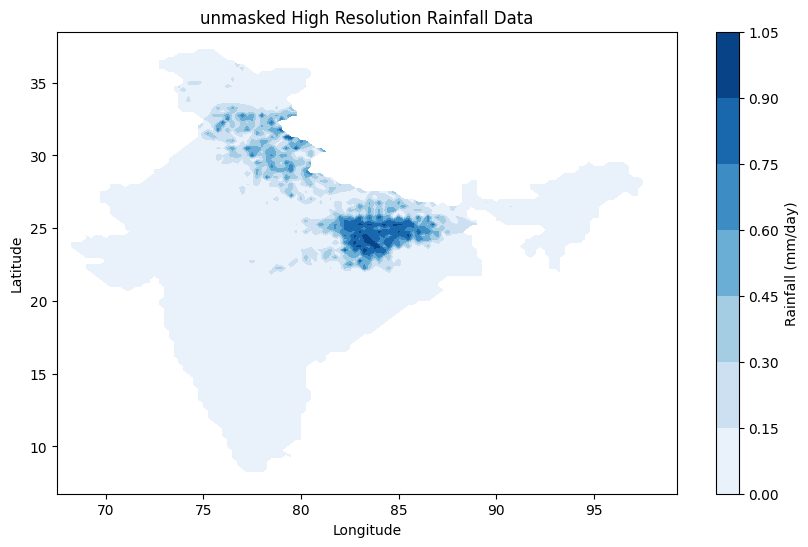

Epoch 6, Generator Loss: 344.38482666015625, Discriminator Loss: -4.479889869689941
Models saved after epoch 6
PSNR:31.585983570967386,SSIM:0.9318534006983337 , MSE:0.0009505890551517632
100 batches completed in epoch:7
200 batches completed in epoch:7
300 batches completed in epoch:7
400 batches completed in epoch:7
500 batches completed in epoch:7
600 batches completed in epoch:7
700 batches completed in epoch:7
800 batches completed in epoch:7
900 batches completed in epoch:7
1000 batches completed in epoch:7
1100 batches completed in epoch:7
1200 batches completed in epoch:7
1300 batches completed in epoch:7
128 128


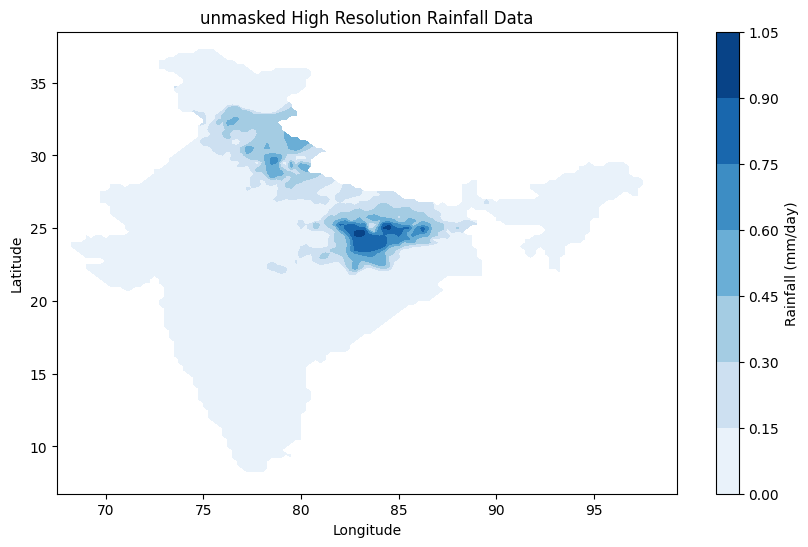

128 128


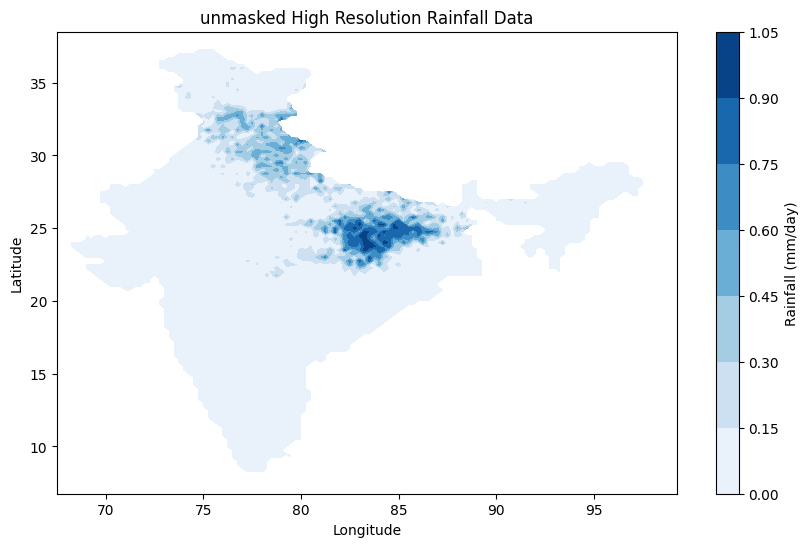

Epoch 7, Generator Loss: 363.31494140625, Discriminator Loss: -4.7180047035217285
Models saved after epoch 7
PSNR:31.433138721131037,SSIM:0.9289940215127889 , MSE:0.0009917855542990962
100 batches completed in epoch:8
200 batches completed in epoch:8
300 batches completed in epoch:8
400 batches completed in epoch:8
500 batches completed in epoch:8
600 batches completed in epoch:8
700 batches completed in epoch:8
800 batches completed in epoch:8
900 batches completed in epoch:8
1000 batches completed in epoch:8
1100 batches completed in epoch:8
1200 batches completed in epoch:8
1300 batches completed in epoch:8
128 128


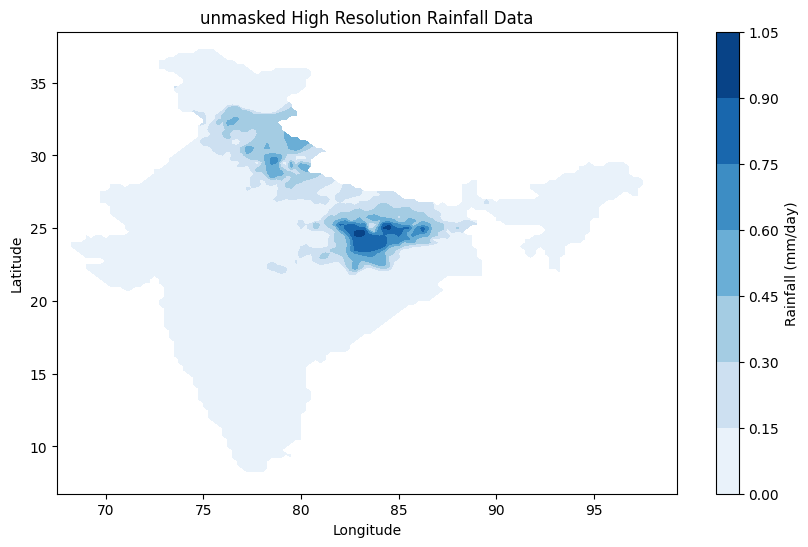

128 128


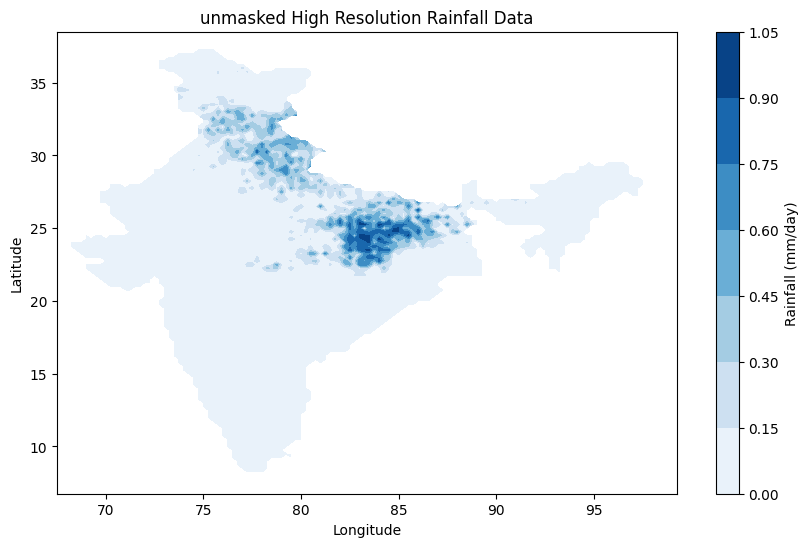

Epoch 8, Generator Loss: 383.7350769042969, Discriminator Loss: -4.6852126121521
Models saved after epoch 8
PSNR:31.565545821241262,SSIM:0.929237615368211 , MSE:0.000963322529474637
100 batches completed in epoch:9
200 batches completed in epoch:9
300 batches completed in epoch:9
400 batches completed in epoch:9
500 batches completed in epoch:9
600 batches completed in epoch:9
700 batches completed in epoch:9
800 batches completed in epoch:9
900 batches completed in epoch:9
1000 batches completed in epoch:9
1100 batches completed in epoch:9
1200 batches completed in epoch:9
1300 batches completed in epoch:9
128 128


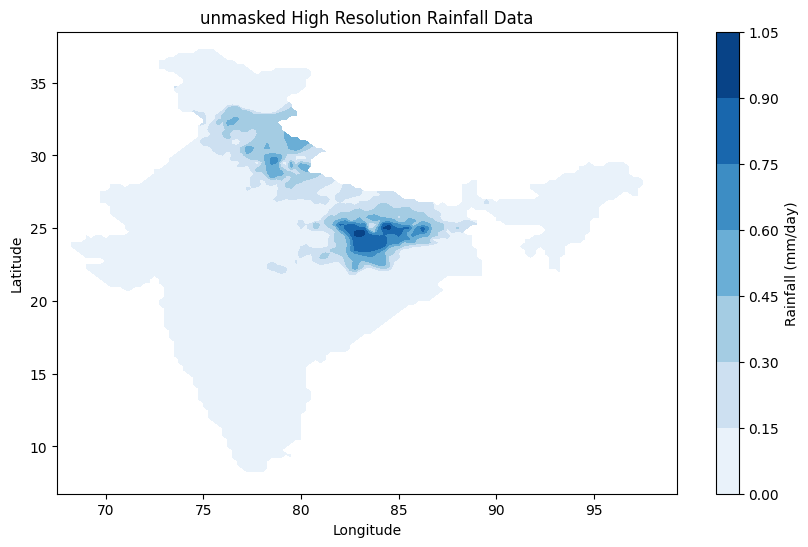

128 128


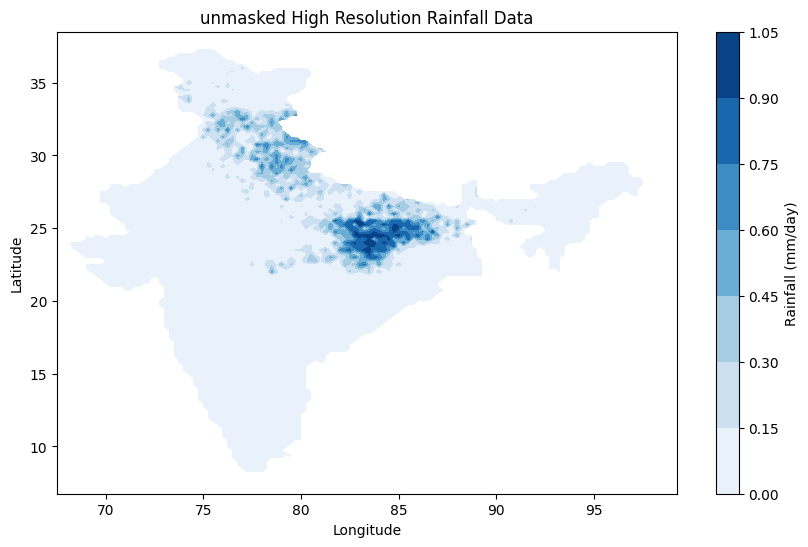

Epoch 9, Generator Loss: 329.7588806152344, Discriminator Loss: -4.932523727416992
Models saved after epoch 9
PSNR:31.448017545470112,SSIM:0.931109352733635 , MSE:0.0009941677942976845
100 batches completed in epoch:10
200 batches completed in epoch:10
300 batches completed in epoch:10
400 batches completed in epoch:10
500 batches completed in epoch:10
600 batches completed in epoch:10
700 batches completed in epoch:10
800 batches completed in epoch:10
900 batches completed in epoch:10
1000 batches completed in epoch:10
1100 batches completed in epoch:10
1200 batches completed in epoch:10
1300 batches completed in epoch:10
128 128


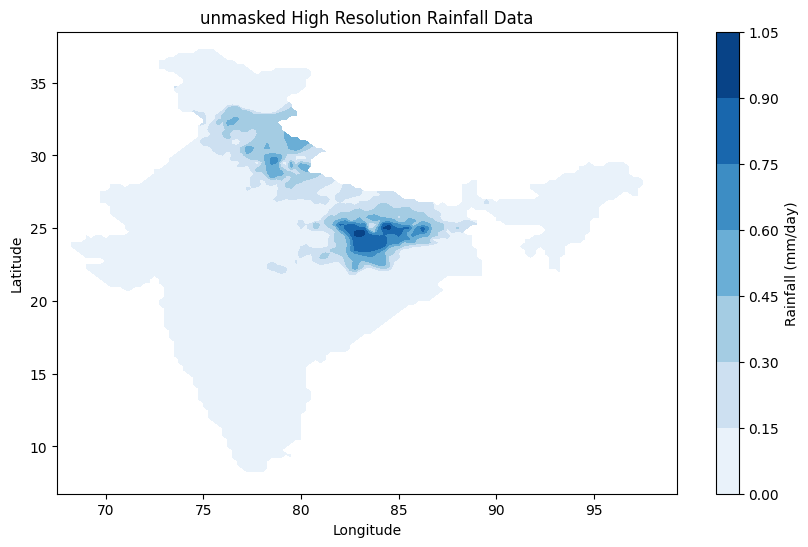

128 128


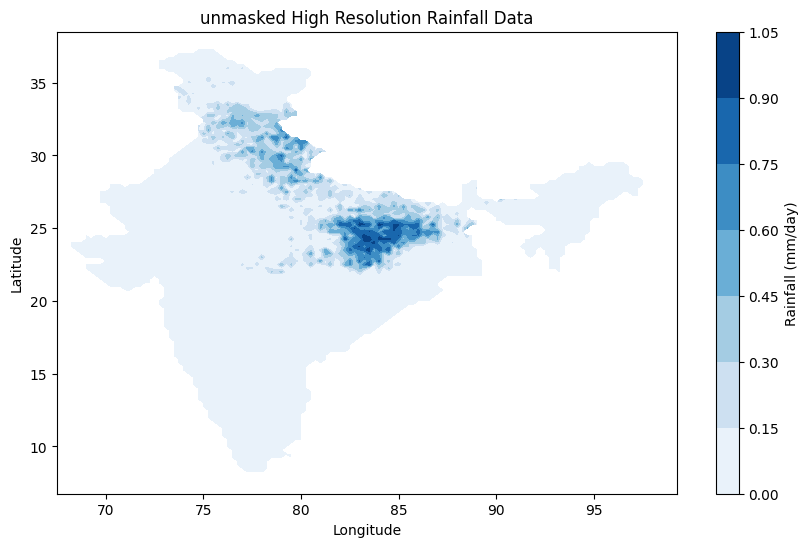

Epoch 10, Generator Loss: 353.01751708984375, Discriminator Loss: -5.01455545425415
Models saved after epoch 10
PSNR:31.239542957258127,SSIM:0.9276110009604047 , MSE:0.0010388172358813555


In [11]:
train(SR_data_processed,LR_data_processed,PSNR,SSIM,epochs=10, batch_size=32)

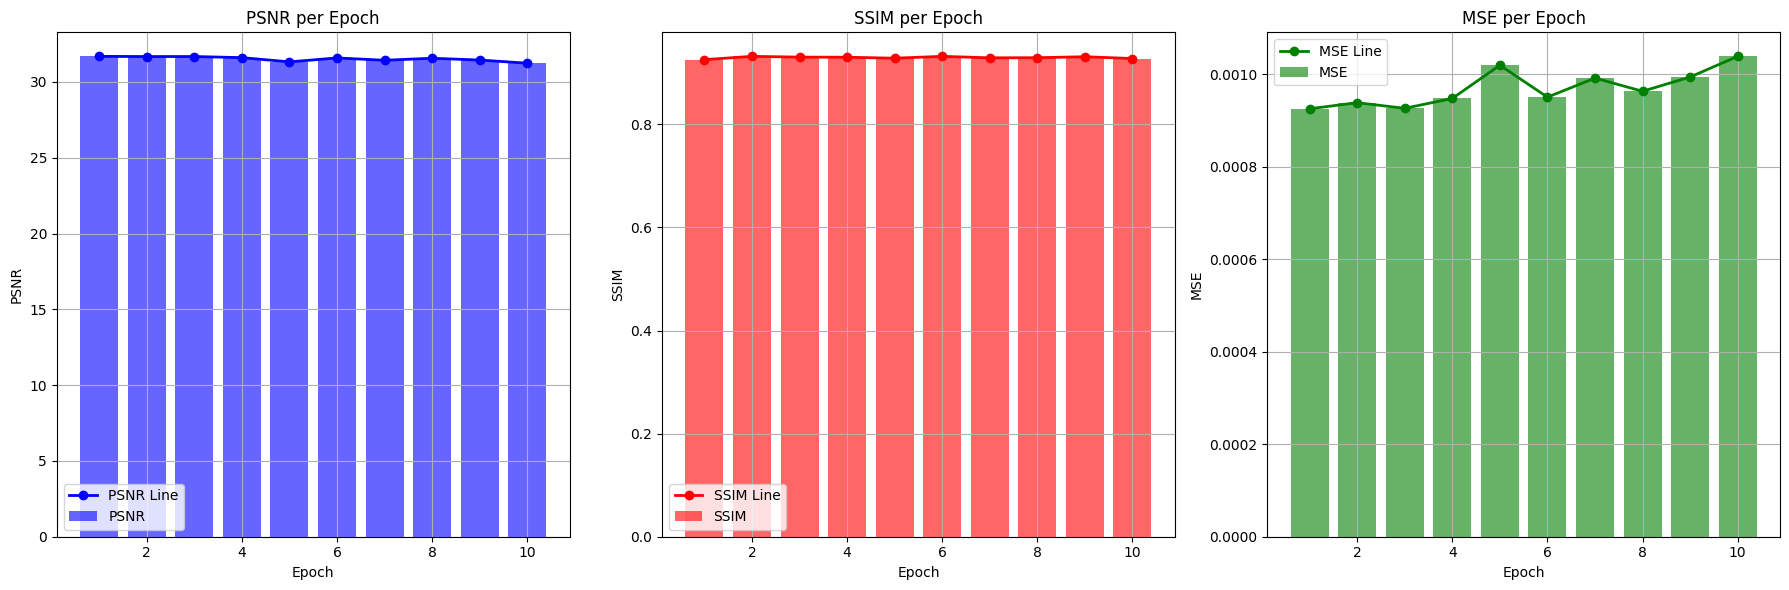

In [12]:
tn.plot_metrics(PSNR,SSIM,MSE)

In [13]:
HR = Generator(np.array(SR_data_processed[0]).reshape((1,128,128,1)))
HR = np.array(HR).reshape(512,512)

In [14]:
import tensorflow as tf
import numpy as np
from scipy.ndimage import gaussian_filter

# First upsample using the original method
upsampled_image = tf.keras.layers.UpSampling2D(size=(2, 2))(SR_data_base[0].reshape((1, 128, 128, 1)))
upsampled_image = tf.keras.layers.UpSampling2D(size=(2, 2))(upsampled_image)

# Convert the result to numpy array for applying Gaussian blur
upsampled_image_np = upsampled_image.numpy()

# Apply Gaussian blur to smooth the edges
# Adjust sigma as per need (start with 0.5 for minimal smoothing)
smoothed_image = gaussian_filter(upsampled_image_np, sigma=0.5)

# Create mask for NaN values if needed
mask = np.isnan(smoothed_image)

In [15]:
HR[mask.reshape(512,512)] = np.nan

128 128


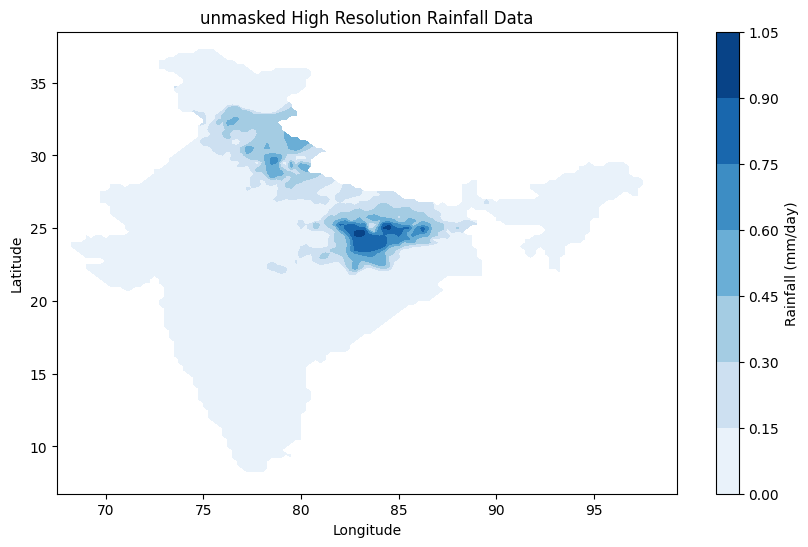

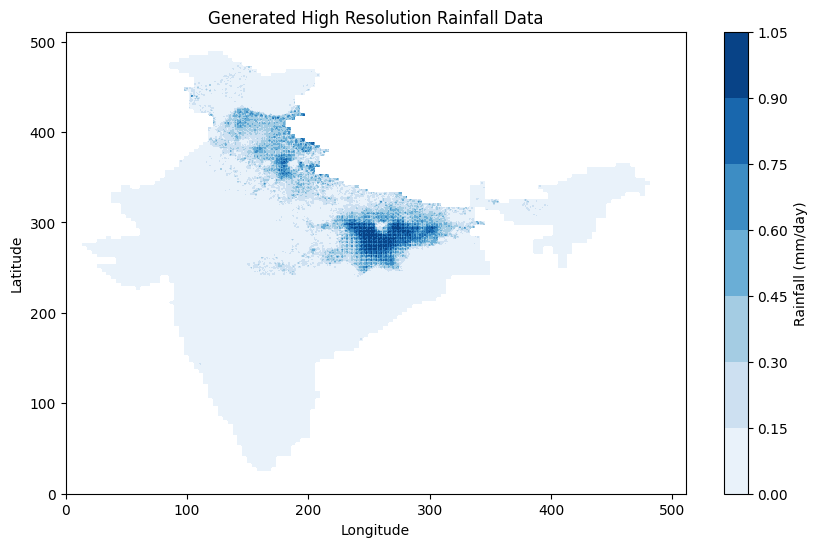

In [16]:
dp.visualize_SR_masked_data(SR_data_processed[0],SR_mask[0])
lat25 = np.load('/kaggle/input/coordinates-imd/0.25lat.npy')
lon25 = np.load('/kaggle/input/coordinates-imd/0.25lon.npy')[4:-4]
lon = np.arange(len(lon25) * 4)
lat = np.arange(len(lat25) * 4)
X_SR, Y_SR = np.meshgrid(lon, lat)
plt.figure(figsize=(10, 6))   
plt.contourf(X_SR, Y_SR,HR , cmap='Blues')
plt.colorbar(label='Rainfall (mm/day)')
plt.title('Generated High Resolution Rainfall Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()